#### Adult Dataset

In [23]:
import pandas as pd

# 定义数据集的列名
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]
# 数据集的URL
url = "./adult.csv"

# 使用pandas加载数据集
df = pd.read_csv(url, header=None, names=column_names, skipinitialspace=True)

# 取10条数据
df_sample = df.head(10)
df_sample

FileNotFoundError: [Errno 2] No such file or directory: './adult.csv'

In [ ]:
# 制定映射规则，全都转为数值型
# 只取age, education-num, capital-gain, capital-loss, hours-per-week列
input_X = df.iloc[:, [0, 4, 10, 11, 12]]
# input_X转为ndarray
input_X = input_X.values
# input_X
y = df['income']
df_y = y.str.strip().str.rstrip('.')
# 制定df_y的映射规则
maps = {'<=50K': 0, 
       '>50K': 1}
input_y = df_y.map(maps).values
input_X = input_X[:1000]
input_y = input_y[:1000]

input_X.shape, input_y.shape

((1000, 5), (1000,))

#### 构建邻接矩阵

Text(0.5, 1.0, 'Adult dataset Visualization')

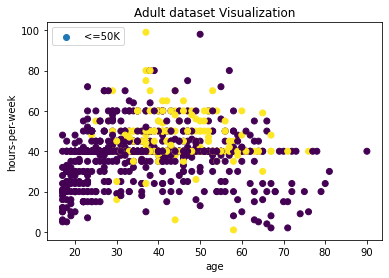

In [ ]:
nodes = []
index = 0
from AdultNode import Node, Graph

for df, y in zip(input_X, input_y):
    node = Node(df, y, index)
    nodes.append(node)
    index += 1

%matplotlib inline
from matplotlib import pyplot as plt
# age, education-num, capital-gain, capital-loss, hours-per-week
plt.scatter(input_X[:, 0], input_X[:, 4], c=input_y)
# 图例
plt.legend(['<=50K', '>50K'], loc='upper left')
# 横轴名称：age， 纵轴名称：hours-per-week
plt.xlabel('age')
plt.ylabel('hours-per-week')
# 标题：Adult dataset: Initial Distribution
title = 'Adult dataset Visualization'
plt.title(title)

In [ ]:
import numpy as np
DISTANCE = 5
graph = Graph(nodes, distance=DISTANCE)
adjacency_matrix = np.array(graph.get_adjacency_matrix())
print("邻接矩阵：", adjacency_matrix.shape)

#根据邻接矩阵获取所有的二元组，如：[(0, 1), (0, 2), (1, 2)]
edges = graph.get_edges()
print(f"Distance={DISTANCE}, 构建了{len(edges)}条边")

邻接矩阵： (1000, 1000)
Distance=5, 构建了17687条边


#### DeepWalk

In [ ]:
import networkx as nx
from util import deepwalk

# Usage
nx = graph.to_nx()
embeddings = deepwalk(nx, walk_length=60, num_walks=200, dim=32)
# print(type(embeddings))


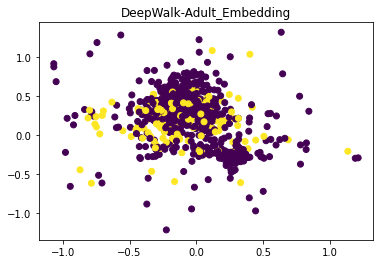

In [ ]:
# 取两维做个可视化
# 随便取两个维度看看
x = [embedding[0] for embedding in list(embeddings.values()) if embedding is not None]
y = [embedding[1] for embedding in list(embeddings.values()) if embedding is not None]

label = [node.label for node in nodes if(embeddings[str(node.index)] is not None)]

# 创建散点图
plt.scatter(x, y, c=label)
plt.title("DeepWalk-Adult_Embedding")
# 显示图形
plt.show()

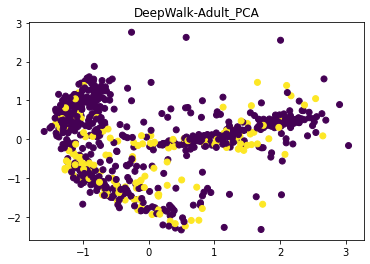

In [ ]:
#PCA降维
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 先drop掉None
embeddings = {key: value for key, value in embeddings.items() if value is not None}
# 假设embeddings是一个字典，其中包含嵌入值
embeddings_value = list(embeddings.values())

# 使用PCA进行降维
pca = PCA(n_components=2)
pca.fit(embeddings_value)
X_pca = pca.transform(embeddings_value)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=label)
plt.title("DeepWalk-Adult_PCA")
plt.show()


#### Node2Vec

In [ ]:
import networkx as nx
import gensim
import random

def node2vec(graph, walk_length=60, num_walks=200, p=1.0, q=1.0, dim=32):
    # Generate random walk sequences
    walks = []
    for _ in range(num_walks):
        node = random.choice(list(graph.nodes))
        walk = [node]
        while len(walk) < walk_length:
            neighbors = list(graph.neighbors(node))
            if len(neighbors) > 0:
                if len(walk) == 1 or random.random() < p:
                    # Choose a neighbor at random with probability P
                    next_node = random.choice(neighbors)
                else:
                    # Choose a neighbor with probability proportional to the inverse of the square of the distance to the previous node
                    weights = [1.0 / q if n == walk[-1] else 1.0 for n in neighbors]
                    next_node = random.choices(neighbors, weights)[0]
                walk.append(next_node)
                node = next_node
            else:
                break
        walks.append(walk)

    # Use gensim's Word2Vec to train embedding vectors
    sentences = [list(map(str, walk)) for walk in walks]
    model = gensim.models.Word2Vec(sentences, vector_size=dim, window=walk_length, min_count=1, sg=1)
    node2vec = {str(node): model.wv[str(node)] if str(node) in model.wv else None for node in graph.nodes}
    return node2vec

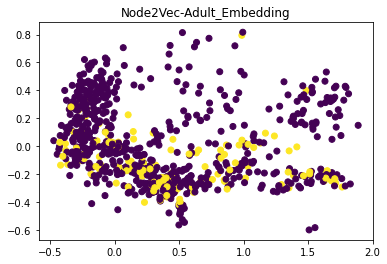

In [ ]:
nx = graph.to_nx()
# print(nx.nodes)
embeddings = node2vec(nx)
# embeddings

# 随便取两个维度看看
x = [embedding[0] for embedding in list(embeddings.values()) if embedding is not None]
y = [embedding[1] for embedding in list(embeddings.values()) if embedding is not None]



label = [node.label for node in nodes if(embeddings[str(node.index)] is not None)]

# 创建散点图
plt.scatter(x, y, c=label)
plt.title("Node2Vec-Adult_Embedding")
# 显示图形
plt.show()

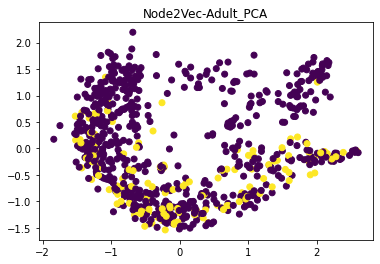

In [ ]:
#PCA降维
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 先drop掉None
embeddings = {key: value for key, value in embeddings.items() if value is not None}
# 假设embeddings是一个字典，其中包含嵌入值
embeddings_value = list(embeddings.values())

# 使用PCA进行降维
pca = PCA(n_components=2)
pca.fit(embeddings_value)
X_pca = pca.transform(embeddings_value)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=label)
plt.title("Node2Vec-Adult_PCA")
plt.show()


### GIN

输入形状: torch.Size([2490, 502]) torch.Size([2, 747000])
2.027888774871826
输入形状: torch.Size([2490, 502]) torch.Size([2, 747000])
35.08427810668945
输入形状: torch.Size([2490, 502]) torch.Size([2, 747000])
265.9711608886719
输入形状: torch.Size([2490, 502]) torch.Size([2, 747000])
9873.4912109375
输入形状: torch.Size([2490, 502]) torch.Size([2, 747000])
116274.4296875
输入形状: torch.Size([2490, 502]) torch.Size([2, 747000])
330.87322998046875
输入形状: torch.Size([2490, 502]) torch.Size([2, 747000])
497.255126953125
输入形状: torch.Size([2490, 502]) torch.Size([2, 747000])
4.682919025421143
输入形状: torch.Size([2490, 502]) torch.Size([2, 747000])
28.266263961791992
输入形状: torch.Size([2490, 502]) torch.Size([2, 747000])
19.25635528564453


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f032d0e3d30>
Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/root/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/root/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/root/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


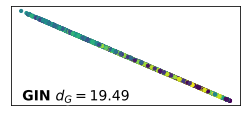

In [28]:
import os
import csv
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from scipy.sparse import csr_matrix
import networkx as nx

from scipy.linalg import orthogonal_procrustes

import torch
import torch.optim as optim
from torch_geometric.data import Data

from sklearn.manifold import TSNE

from util import GIN, stationary, reconstruct, dG


np.random.seed(0)
torch.manual_seed(0)

x = []
with open('./adult.data') as f:
    reader = csv.reader(f)
    for r in reader:
        if len(r) == 15 and int(r[0]) < 90 and 1000 < int(r[10]) and int(r[10]) < 99999:
            x.append([int(r[0]), np.log10(int(r[10]))])

x = np.array(x)
mu = np.mean(x, axis=0, keepdims=True)
std = np.std(x, axis=0, keepdims=True)
x = (x - mu) / std
n = len(x)
m = 500
n_train = int(n * 0.7)
train_ind = torch.randperm(n)[:n_train]
test_ind = torch.LongTensor(list(set(np.arange(n)) - set(train_ind.tolist())))
K = 300
D = pairwise_distances(x) - 1e9 * np.eye(n)
fr = np.arange(n).repeat(K).reshape(-1)
to = np.argsort(D, axis=1)[:, 1:K + 1].reshape(-1)
A = csr_matrix((np.ones(n * K) / K, (fr, to)))

edge_index = np.vstack([fr, to])
edge_index = torch.tensor(edge_index, dtype=torch.long)
X = torch.tensor([[K, n] for i in range(n)], dtype=torch.float)

net = GAT(m)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
for epoch in range(10):
    ind = torch.eye(n)[:, torch.randperm(n)[:m]]
    X_extended = torch.hstack([X, ind])
    data = Data(x=X_extended, edge_index=edge_index)
    rec = net(data)
    loss = dG(torch.FloatTensor(x)[train_ind], rec[train_ind])
    print(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

R, _ = orthogonal_procrustes(x, rec.detach().numpy())
rec_GIN = rec.detach().numpy() @ R.T
loss_GAT = float(dG(torch.FloatTensor(x), rec))

ind = torch.eye(n)[:, torch.randperm(n)[:m]]
X_extended = torch.hstack([X, ind])
X_embedded = TSNE(n_components=2, random_state=0, init='pca').fit_transform(X_extended.numpy())
loss_tSNE = float(dG(torch.FloatTensor(x), X_embedded))

c = x[:, 0].argsort().argsort()
fig = plt.figure(figsize=(14, 4))

# ... 其他可视化代码 ...

ax = fig.add_subplot(2, 3, 5)
ax.scatter(rec_GIN[:, 0], rec_GIN[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'GIN $d_G = {:.2f}$'.format(loss_GIN), color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

# ... 其他可视化代码 ...

fig.subplots_adjust()

if not os.path.exists('imgs'):
    os.mkdir('imgs')

fig.savefig('imgs/semi_adult_GIN.png', bbox_inches='tight', dpi=300)


In [29]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error

y_true = np.array(X)  # 真实值
y_pred = np.array(rec_GIN)  # 预测值

print(y_true.shape, y_pred.shape)

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print(f'均方误差（MSE）：{mse}')
print(f'均方根误差（RMSE）：{rmse}')
print(f'平均绝对误差（MAE）：{mae}')

(2490, 2) (2490, 2)
均方误差（MSE）：3139908.7793926853
均方根误差（RMSE）：1771.9787750965545
平均绝对误差（MAE）：1395.289777405611


#### GAT

2.0277833938598633
2.0275728702545166
2.0275373458862305
2.027401924133301
2.026559591293335
2.026721954345703
2.0256762504577637
2.024500608444214
2.024585247039795
2.021973133087158


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f028d742670>
Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/root/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/root/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/root/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


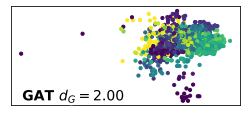

In [31]:
import os
import csv
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from scipy.sparse import csr_matrix
import networkx as nx

from scipy.linalg import orthogonal_procrustes

import torch
import torch.optim as optim
from torch_geometric.data import Data

from sklearn.manifold import TSNE

from util import GIN, stationary, reconstruct, dG, GAT


np.random.seed(0)
torch.manual_seed(0)

x = []
with open('./adult.data') as f:
    reader = csv.reader(f)
    for r in reader:
        if len(r) == 15 and int(r[0]) < 90 and 1000 < int(r[10]) and int(r[10]) < 99999:
            x.append([int(r[0]), np.log10(int(r[10]))])

x = np.array(x)
mu = np.mean(x, axis=0, keepdims=True)
std = np.std(x, axis=0, keepdims=True)
x = (x - mu) / std
n = len(x)
m = 500
n_train = int(n * 0.7)
train_ind = torch.randperm(n)[:n_train]
test_ind = torch.LongTensor(list(set(np.arange(n)) - set(train_ind.tolist())))
K = 300
D = pairwise_distances(x) - 1e9 * np.eye(n)
fr = np.arange(n).repeat(K).reshape(-1)
to = np.argsort(D, axis=1)[:, 1:K + 1].reshape(-1)
A = csr_matrix((np.ones(n * K) / K, (fr, to)))

edge_index = np.vstack([fr, to])
edge_index = torch.tensor(edge_index, dtype=torch.long)
X = torch.tensor([[K, n] for i in range(n)], dtype=torch.float)

net = GAT(m)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
for epoch in range(10):
    ind = torch.eye(n)[:, torch.randperm(n)[:m]]
    X_extended = torch.hstack([X, ind])
    data = Data(x=X_extended, edge_index=edge_index)
    rec = net(data)
    loss = dG(torch.FloatTensor(x)[train_ind], rec[train_ind])
    print(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

R, _ = orthogonal_procrustes(x, rec.detach().numpy())
rec_GAT = rec.detach().numpy() @ R.T
loss_GAT = float(dG(torch.FloatTensor(x), rec))

ind = torch.eye(n)[:, torch.randperm(n)[:m]]
X_extended = torch.hstack([X, ind])
X_embedded = TSNE(n_components=2, random_state=0, init='pca').fit_transform(X_extended.numpy())
loss_tSNE = float(dG(torch.FloatTensor(x), X_embedded))

c = x[:, 0].argsort().argsort()
fig = plt.figure(figsize=(14, 4))

# ... 其他可视化代码 ...

ax = fig.add_subplot(2, 3, 5)
ax.scatter(rec_GAT[:, 0], rec_GAT[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'GAT $d_G = {:.2f}$'.format(loss_GAT), color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

# ... 其他可视化代码 ...

fig.subplots_adjust()

if not os.path.exists('imgs'):
    os.mkdir('imgs')

fig.savefig('imgs/semi_adult_GAT.png', bbox_inches='tight', dpi=300)
